In [1]:
import random
import colorednoise as cn
import pandas as pd
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import yaml
import torch.nn.functional as F
from torchlibrosa.augmentation import SpecAugmentation
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
from IPython.display import Audio
from efficientnet_pytorch import EfficientNet
sys.path.append("../input/modules")
import datasets
from datasets import RainForestDataset
from datasets.augmentation import *
from utils import logmelfilterbank
from utils import read_hdf5
from utils import down_sampler
from utils import get_concat_down_frame
from utils import get_down_sample_matrix
from models.conformer import *
from models import *
from losses import FrameClipLoss
from datasets import FeatTrainCollater
from datasets import FeatEvalCollater
from utils import lwlrap
sys.path.append("../input/iterative-stratification-master")
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
%load_ext autoreload
%autoreload 2

In [2]:
train_tp = pd.read_csv('../input/rfcx-species-audio-detection/train_tp.csv')
train_fp = pd.read_csv('../input/rfcx-species-audio-detection/train_fp.csv')
submission = pd.read_csv('../input/rfcx-species-audio-detection/sample_submission.csv')
tmp = pd.DataFrame(train_tp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_tp["t_diff"] = train_tp["t_max"] - train_tp["t_min"]
train_tp["f_diff"] = train_tp["f_max"] - train_tp["f_min"]
train_fp["t_diff"] = train_fp["t_max"] - train_fp["t_min"]
train_fp["f_diff"] = train_fp["f_max"] - train_fp["f_min"]
train_tp = pd.merge(train_tp, tmp, on="recording_id", how='inner')
train_tp["count"].value_counts()
tp_list = train_tp["recording_id"].unique()
fp_list = train_fp["recording_id"].unique()

In [3]:
tmp = pd.DataFrame(train_fp["recording_id"].value_counts()).reset_index().rename(columns={'index': 'recording_id', "recording_id": "count"})
train_fp = pd.merge(train_fp, tmp, on="recording_id", how='inner')
train_fp["count"].value_counts()

1     2028
2     1716
3     1635
4     1356
5      575
6      294
7      126
8       32
10      10
9        9
Name: count, dtype: int64

In [4]:
train_path_list = os.listdir("../input/rfcx-species-audio-detection/train")
test_path_list = os.listdir("../input/rfcx-species-audio-detection/test")
print(f"train:{len(train_path_list)}, test:{len(test_path_list)}")
# print("train")
# for path in tqdm(train_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/train", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)
# print("test")
# for path in tqdm(test_path_list):
#     path = os.path.join("../input/rfcx-species-audio-detection/test", path)
#     y, sr = librosa.load(path=path, sr=None)
#     if (sr != 48000) or (len(y) != 2880000):
#         print(path, y.shape, sr)

train:4727, test:1992


In [6]:
path = "dump/wave/train/551385b05.h5" # "dump/wave/train/c12e0a62b.h5"
wave = read_hdf5(hdf5_name=path, hdf5_path="wave")
mel = read_hdf5(hdf5_name=path, hdf5_path="feats")
matrix_tp = read_hdf5(hdf5_name=path, hdf5_path="matrix_tp")
matrix_fp = read_hdf5(hdf5_name=path, hdf5_path="matrix_fp")
print(wave.shape)
# plt.figure(figsize=(16, 8))
# plt.subplot(2, 2, 1)
# plt.plot(wave)
# plt.subplot(2, 2, 2)
# plt.imshow(mel.T, aspect="auto")
# plt.colorbar()
# plt.subplot(2, 2, 3)
# plt.imshow(matrix_tp.T, aspect="auto")
# plt.subplot(2, 2, 4)
# plt.imshow(matrix_fp.T, aspect="auto")
# plt.colorbar()

(2880000,)


In [ ]:
y_frame = torch.stack([torch.tensor(down_sampler(matrix_tp[3000:3512])), torch.tensor(down_sampler(matrix_tp[4500:5012]))], dim=0)
y_clip = torch.tensor((y_frame>0).any(axis=1), dtype=torch.float)
x_batch = torch.stack([torch.tensor(mel[3000:3512]), torch.tensor(mel[4500:5012])], dim=0).transpose(2,1)
print(y_frame.shape, y_clip.shape)
model = Cnn14_DecisionLevelAtt(sample_rate=16000,
        window_size=1024,
        hop_size=256,
        mel_bins=64,
        fmin=50,
        fmax=8000,
        classes_num=24,
        training=False,
        require_prep=False,
        is_spec_augmenter=False,
        mixup_lambda=None,)
model.bn0 = nn.BatchNorm2d(128)
y = model(x_batch)
bce = nn.BCEWithLogitsLoss(reduction="mean")
print(y["y_frame"].shape, y["y_clip"].shape)

In [ ]:
criterion = FrameClipLoss()
loss = criterion(y["y_frame"], y_frame, y["y_clip"], y_clip)
print(loss.item())
loss.backward(retain_graph=True)
# clip_loss = bce(y["y_clip"], y_clip)
# frame_loss = bce(y["y_frame"], y_frame)
# print(clip_loss.item())
# print(frame_loss.item())
# clip_loss.backward(retain_graph=True)
# frame_loss.backward(retain_graph=True)


In [10]:
columns = ["recording_id"] + [f"s{i}" for i in range(24)]
ground_truth = pd.DataFrame(np.zeros((len(tp_list), 25)), columns=columns)
ground_truth["recording_id"] = train_tp["recording_id"].unique()
for i, recording_id in enumerate(train_tp["recording_id"].values):
    ground_truth.iloc[ground_truth["recording_id"]==recording_id, train_tp.loc[i, "species_id"]+1] = 1.0

kfold = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=1)
y = ground_truth.iloc[:, 1:].values
for i, (train_idx, valid_idx) in enumerate(kfold.split(y, y)):
    train_y = ground_truth.iloc[train_idx]
    valid_y = ground_truth.iloc[valid_idx]
    if i == 0:
        break
train_dataset = RainForestDataset(
    root_dirs=["dump/wave/train"],
    train_tp=train_tp,
    train_fp=None,
    keys=["feats"],
    mode="tp",
    is_normalize=False,
    allow_cache=False,
    seed=None,
)
eval_dataset = RainForestDataset(
    files=[
        os.path.join("dump/wave/train", f"{recording_id}.h5")
        for recording_id in tp_list[valid_idx]
    ],
    keys=["feats", "matrix_tp"],
    mode="test",
    is_normalize=False,
    allow_cache=False,
    seed=None,
        )

train_collater = FeatTrainCollater(
    max_frames=512,
    l_target=16,
    mode="binary",
    random=False
)
eval_collater = FeatEvalCollater(
    max_frames=512,
    n_split=3,
    is_label=True,
)
data_loader = {
"train": DataLoader(
        dataset=train_dataset,
        batch_size=64,
        collate_fn=train_collater,
        shuffle=False,
        num_workers=1,
        pin_memory=False,
    ),
"eval": DataLoader(
        eval_dataset,
        batch_size=64,
        shuffle=False,
        collate_fn=eval_collater,
        num_workers=1,
        pin_memory=False,
    ),
}
clip_list = []
for i, batch in enumerate(data_loader["train"]):
    x = batch["X"]
    y_frame = batch["y_frame"]
    y_clip = batch["y_clip"]
    clip_list.append(y_clip)
    print(x.shape)
    print(y_frame.shape)
    print(y_clip.shape)
    if i == 0:
        break

torch.Size([64, 128, 512])
torch.Size([64, 16, 25])
torch.Size([64, 25])


In [ ]:
x1 = []
y1_clip = []
beginnings1 = []
for i, batch in enumerate(data_loader["train"]):
    x1.append(batch["X"])
    y1_clip.append(batch["y_clip"])
    beginnings1.append(batch["beginnings"])
    if i == 0:
        break
x2 = []
y2_clip = []
beginnings2 = []
for i, batch in enumerate(data_loader["train"]):
    x2.append(batch["X"])
    y2_clip.append(batch["y_clip"])
    beginnings2.append(batch["beginnings"])
    if i == 0:
        break
xx1 = torch.cat(x1, dim=0)
xx2 = torch.cat(x2, dim=0)
yy1_clip = torch.cat(y1_clip, dim=0)
yy2_clip = torch.cat(y2_clip, dim=0)
ans = xx1 - xx2
print(ans.sum())

In [ ]:
x1 = []
y1_clip = []
for i, batch in enumerate(data_loader["train"]):
    x1.append(batch["X"])
    y1_clip.append(batch["y_clip"])
x2 = []
y2_clip = []
for i, batch in enumerate(data_loader["train"]):
    x2.append(batch["X"])
    y2_clip.append(batch["y_clip"])


In [ ]:
xx1 = torch.cat(x1, dim=0)
xx2 = torch.cat(x2, dim=0)
yy1_clip = torch.cat(y1_clip, dim=0)
yy2_clip = torch.cat(y2_clip, dim=0)
ans = xx1 - xx2
print(ans.sum())

In [ ]:
xx1.shape

In [ ]:
mode = "valid"
n_eval_split = 3
device = "cpu"
n_class = 24
l_spec = 16
keys_list = [f"X{i}" for i in range(n_eval_split)]
y_clip = [
    torch.empty((0, n_class)).to(device)
    for _ in range(n_eval_split)
]
y_frame = [
    torch.empty((0, l_spec, n_class)).to(device)
    for _ in range(n_eval_split)
]
y_clip_true = torch.empty((0, n_class))
model.eval()
with torch.no_grad():
    for batch in data_loader["eval"]:
        if mode == "valid":
            y_clip_true = torch.cat([y_clip_true, batch["y_clip"]], dim=0)
        x_batchs = [batch[key].to(device) for key in keys_list]
        for i in range(n_eval_split):
            y_batch_ = model(x_batchs[i])
            y_clip[i] = torch.cat([y_clip[i], y_batch_["y_clip"]], dim=0)
            y_frame[i] = torch.cat([y_frame[i], y_batch_["y_frame"]], dim=0)
# (B, n_eval_split, n_class)
y_clip = torch.stack(y_clip, dim=0).detach().cpu().numpy()
# (B, n_eval_split, T, n_class)
y_frame = torch.stack(y_frame, dim=0).detach().cpu().numpy()
if mode == "valid":
    y_clip_true = y_clip_true.numpy()
    score = lwlrap(y_clip_true, y_clip.max(axis=0))
    print(f"score:{score:.6f}")


In [20]:
ground_truth = pd.read_csv("../input/rfcx-species-audio-detection/ground_truth.csv")
tag = "v010"
type = "wave"
model_name = "EfficientNet"
with open(f"conf/tuning/{model_name}.{tag}.yaml") as f:
    config = yaml.load(f, Loader=yaml.Loader)
oof_path = f"exp/{type}/{model_name}/{tag}/best_score/oof.h5"
y_clip = read_hdf5(oof_path, "y_clip")
y_frame = read_hdf5(oof_path, "y_frame")
print(y_clip.shape, y_frame.shape)

(1132, 12, 24) (1132, 12, 32, 24)


In [7]:
idx = 6
recording_id = ground_truth.loc[idx, "recording_id"]
print(recording_id)
dump_path = f"dump/{type}/train/{recording_id}.h5"
feats = read_hdf5(dump_path, "feats")
idx_matrix = read_hdf5(dump_path, "matrix_tp")
l_original = len(idx_matrix)
ground_truth_frame = get_down_sample_matrix(idx_matrix, l_target=config["l_target"], max_frames=config["max_frames"], n_eval_split=config["n_eval_split"], mode="binary")
concat_y_frame = get_concat_down_frame(y_frame[idx], l_original=l_original, max_frames=config["max_frames"])
concat_ground_truth = get_concat_down_frame(ground_truth_frame, l_original=l_original, max_frames=config["max_frames"])

true_clip = idx_matrix.any(axis=0).astype(np.int64)[:24].reshape(1, -1)
pred_clip = y_clip[idx].max(axis=0)[:24].reshape(1, -1)
pred_frame_clip = concat_y_frame.max(axis=0)[:24].reshape(1, -1)
score1 = lwlrap(true_clip, pred_clip)
score2 = lwlrap(true_clip, pred_frame_clip)
score3 = lwlrap(true_clip, pred_clip+pred_frame_clip)

print(f"clip:{score1:.5f}, frame: {score2:.5f}, ensemble: {score3:.5f}")

00d442df7
clip:0.33333, frame: 0.33333, ensemble: 0.33333


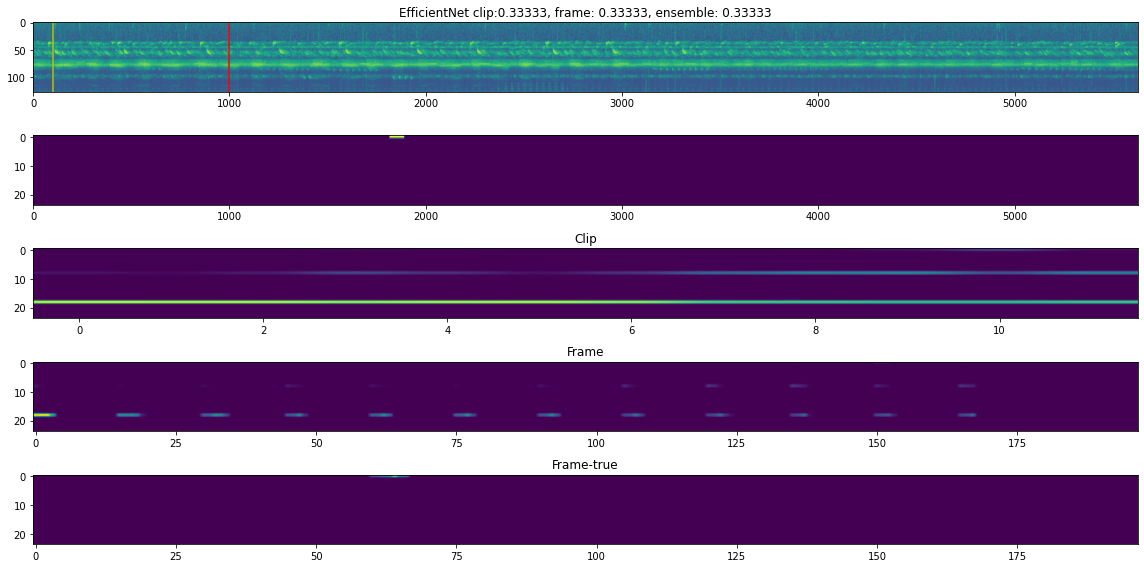

In [14]:
plt.figure(figsize=(16, 8))
n_fig = 5
plt.subplot(n_fig, 1, 1)
plt.title(f"{model_name} clip:{score1:.5f}, frame: {score2:.5f}, ensemble: {score3:.5f}")
plt.imshow(feats.T, aspect="auto")
plt.axvline(x=100, c="y")
plt.axvline(x=1000, c="r")

plt.subplot(n_fig, 1, 2)
plt.imshow(idx_matrix.T, aspect="auto")
plt.subplot(n_fig, 1, 3)
plt.title("Clip")
plt.imshow(y_clip[idx].T, aspect="auto")
plt.subplot(n_fig, 1, 4)
plt.title("Frame")
plt.imshow(concat_y_frame.T, aspect="auto")
plt.subplot(n_fig, 1, 5)
plt.title("Frame-true")
plt.imshow(concat_ground_truth.T, aspect="auto")
plt.tight_layout()

In [ ]:
plt.imshow(concat_y_frame.T, aspect="auto")

In [ ]:
plt.plot(pred_frame_clip.flatten(), alpha=0.5)
plt.plot(true_clip.flatten(), alpha=0.5)

In [ ]:
config["max_frames"]

In [ ]:
resnext50_32x4d = models.resnext50_32x4d(pretrained=True)
x1 = torch.stack([x,x,x]).transpose(1,0)
conv1 = nn.Conv2d(1, 3, 1, 1)
conv_out = conv1(x.unsqueeze(1))
conv_out.shape

In [ ]:
for name,_ in model.named_parameters():
    print(name)

In [ ]:
x = resnext50_32x4d.conv1(x1)
print(x.shape)
x = resnext50_32x4d.bn1(x)
print(x.shape)
x = resnext50_32x4d.relu(x)
print(x.shape)
x = resnext50_32x4d.maxpool(x)
print(x.shape)
x = resnext50_32x4d.layer1(x)
print(x.shape)
x = resnext50_32x4d.layer2(x)
print(x.shape)
x = resnext50_32x4d.layer3(x)
print(x.shape)
x = resnext50_32x4d.layer4(x)
print(x.shape)
x = resnext50_32x4d.avgpool(x)
print(x.shape)
x = torch.flatten(x, 1)
print(x.shape)
y1 = resnext50_32x4d.fc(x)
print(y1.shape)

In [33]:
model = ResNext50(num_mels=128,
        classes_num=24,
        training=False,
        is_spec_augmenter=True)
yy = model(batch["X"])

In [34]:
print(yy["y_frame"].shape, yy["y_clip"].shape, yy["embedding"].shape)

torch.Size([64, 30, 24]) torch.Size([64, 24]) torch.Size([64, 2048])


In [ ]:
from IPython.display import Audio
sr = 48000
i = 5
path = f"dump/wave/train/{tp_list[i]}.h5" # "dump/wave/train/c12e0a62b.h5"
wave = read_hdf5(hdf5_name=path, hdf5_path="wave")
feats = read_hdf5(hdf5_name=path, hdf5_path="feats")
matrix_tp= read_hdf5(hdf5_name=path, hdf5_path="matrix_tp")
# transform = TimeStretch(always_apply=True, max_rate=1.1)
# transform = GaussianNoiseSNR(always_apply=True, min_snr=40.0, max_snr=40.0)
# transform = VolumeControl(always_apply=True,db_limit=10, mode="cosine")
# # transform =PinkNoiseSNR(always_apply=True, min_snr=50.0, max_snr=50.0)
# transform = Compose([
# #   OneOf([
# #     GaussianNoiseSNR(min_snr=10),
# #     PinkNoiseSNR(min_snr=10)
# #   ]),
# #   VolumeControl(mode="sine")
#     PitchShift(max_steps=2, sr=sr)
# ])
wave_ = transform(wave)
feats_ = logmelfilterbank(wave_, sr, fft_size=2048,hop_size=512,window="hann",num_mels=128,fmin=50,fmax=16000)
plt.figure(figsize=(16, 6))
plt.subplot(3, 1, 1)
plt.imshow(matrix_tp.T, aspect="auto")
plt.colorbar()
plt.subplot(3, 1, 2)
plt.title("Original")
plt.imshow(feats.T, aspect="auto")
plt.colorbar()
plt.subplot(3, 1, 3)
plt.imshow(feats_.T, aspect="auto")
plt.title("Augmented")
plt.colorbar()
plt.tight_layout()
# Audio(wave, rate=sr)

In [ ]:
# Audio(wave_, rate=sr)

In [ ]:
# model = ConformerEncoderDecoder(
#     num_features=128,
#     num_classes=24,
#     num_blocks=8,
#     num_channels=144,
#     kernel_size=31,
#     num_heads=4,
#     num_latent_units=32,
#     num_embeddings=0,
#     embedding_dim=0,
#     concat_embedding=False,
#     dropout=0.1,
#     bias=True,
#     use_bottleneck=True,
#     use_reconstruct=True,
#     use_dializer=True,
#     is_spec_augmenter=True,
#     training=True,
#     )
model = TransformerEncoderDecoder(
    num_features=128,
    num_classes=24,
    sequence_length=-1,
    input_layer= "linear",
    num_blocks= 4,
    num_heads= 4,
    num_hidden_units= 64,
    num_feedforward_units = 128,
    num_latent_units =8,
    num_embeddings=0,
    embedding_dim=0,
    concat_embedding=False,
    activation="relu",
    use_position_encode=False,
    max_position_encode_length=512,
    dropout=0.1,
    use_reconstruct=True,
    use_dializer=True,
    is_spec_augmenter=True,
    training=True,
)

In [ ]:
# batch["X_"] = torch.rand(64, 128, 513)
print(batch["X"].transpose(2,1).shape)
y = model(batch["X"].transpose(2,1))
print(y["y_frame"].shape, y["y_clip"].shape)
print(y["frame_mask"].shape)
print(y["reconstructed"].shape)

In [48]:
model = models.mobilenet_v2(pretrained=True)


In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.shape}")

In [52]:
conv1 = nn.Conv2d(1, 3, 1, 1)
x = conv1(batch["X"].unsqueeze(1))
y_ = model.features(x)
print(y_.shape)

torch.Size([64, 1280, 4, 16])


In [32]:
model = EfficientNet_b()
y = model(batch["X"])

Loaded pretrained weights for efficientnet-b0


(array([2.0000e+00, 3.0000e+00, 2.6000e+01, 2.9200e+02, 2.3450e+03,
        1.2177e+04, 8.4270e+03, 1.1490e+03, 1.3300e+02, 2.2000e+01]),
 array([-32.66062  , -27.081799 , -21.502975 , -15.924152 , -10.345329 ,
         -4.766506 ,   0.8123169,   6.39114  ,  11.969963 ,  17.548786 ,
         23.12761  ], dtype=float32),
 <BarContainer object of 10 artists>)

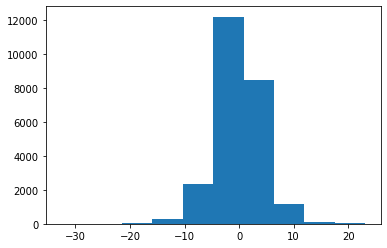

In [55]:
plt.hist(y["y_frame"].detach().numpy().flatten())

In [56]:
a = np.arange(24).reshape(2,3,4).max(axis=1)

In [10]:
train_tp.loc[:,["t_min", "t_max", "species_id"]]

,t_min,t_max,species_id
0,44.5440,45.1307,14
1,39.9615,46.0452,23
2,39.1360,42.2720,12
3,51.4206,55.1996,17
4,50.0854,52.5293,10
...,...,...,...
1211,53.4720,54.0960,13
1212,43.5787,45.7653,4
1213,15.2267,16.0213,0
1214,14.3467,16.6987,5


In [11]:
logmelfilterbank()

23    100
17     68
12     50
1      50
3      50
4      50
5      50
6      50
7      50
8      50
10     50
11     50
13     50
14     50
15     50
16     50
18     50
21     50
0      50
22     44
19     43
20     40
2      37
9      34
Name: species_id, dtype: int64

In [19]:
a = np.linspace(11, 21, 32)
b = (a > 15) & (a < 23)
a[b] = 1
a

array([11.        , 11.32258065, 11.64516129, 11.96774194, 12.29032258,
       12.61290323, 12.93548387, 13.25806452, 13.58064516, 13.90322581,
       14.22580645, 14.5483871 , 14.87096774,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ])

In [31]:
config["sec"] = 10
train_dataset = RainForestDataset(
    root_dirs=["dump/wave/train"],
    train_tp=train_tp,
    train_fp=None,
    keys=["wave"],
    mode="tp",
    is_normalize=False,
    allow_cache=False,
    use_on_the_fly=True,
    config=config,
    seed=None,
)

train_collater = None
data_loader = DataLoader(
        dataset=train_dataset,
        batch_size=64,
        collate_fn=train_collater,
        shuffle=False,
        num_workers=1,
        pin_memory=False,
    )

[autoreload of datasets.rainforest_dataset failed: Traceback (most recent call last):
  File "/home/i_kuroyanagi/workspace5/kaggle/rcsad/tools/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/i_kuroyanagi/workspace5/kaggle/rcsad/tools/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/home/i_kuroyanagi/workspace5/kaggle/rcsad/tools/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/home/i_kuroyanagi/workspace5/kaggle/rcsad/tools/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/home/i_kuroyanagi/workspace5/kaggle/rcsad/tools/venv/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, 

In [32]:
for batch in data_loader:
    print(batch["X"].shape)
    print(batch["y_frame"].shape)
    print(batch["y_clip"].shape)
    break

[44.544  45.1307 14.    ]
[39.9615 46.0452 23.    ]
[39.136 42.272 12.   ]
[51.4206 55.1996 17.    ]
[50.0854 52.5293 10.    ]
[0.0747 4.1973 8.    ]
[19.3653 20.16    0.    ]
[ 5.6853  6.3787 18.    ]
[50.0533 53.3973 15.    ]
[46.032 46.928  1.   ]
[44.24  46.384  6.   ]
[43.3575 45.8014 10.    ]
[50.7573 53.8987  7.    ]
[25.4987 26.2933  0.    ]
[11.9989 13.1367 11.    ]
[ 5.1606  6.2984 11.    ]
[57.808 58.432 13.   ]
[33.9093 37.0453 12.    ]
[21.472  23.3067 16.    ]
[49.632  51.4667 16.    ]
[44.4107 45.2053  0.    ]
[ 0.1227  0.816  18.    ]
[54.384 55.936 19.   ]
[ 4.7307  7.3387 17.    ]
[23.5947 26.736   7.    ]
[23.7013 25.8453  6.    ]
[49.92   50.6613  3.    ]
[ 9.8569 17.7807 23.    ]
[ 0.952   8.8758 23.    ]
[58.992 59.264 14.   ]
[47.5835 50.0274 10.    ]
[ 4.2202  5.358  11.    ]
[31.984 33.76   2.   ]
[26.5867 28.4427  4.    ]
[53.296  54.0907  0.    ]
[22.864 26.    12.   ]
[57.2213 58.016   0.    ]
[1.28   2.0213 3.    ]
[12.496 15.632 12.   ]
[41.36  44.704 15. 

In [38]:
a = 12 > 1
a

True

In [39]:
not a

False